# French presidential election 2022

French presidential election 2022 took place in April and we explore various data analytics on the performance of each candidates.  
We downloaded the voting results of each French department from the [election website](https://www.resultats-elections.interieur.gouv.fr/presidentielle-2022/FE.html) to try our hands at analysing the data available.  

## From notebook to project

📕 In a Jupyter Notebook, we can explore data and prototype our data model in sequential manner. I.e. once we have created a session, we can incrementally add new tables to the cube, create measures as we go along.

📑 For a running application, the program is more structured. I.e. the recommended order of events is as follows:
- create session
- create table(s)
- create hierarchies/measures and apply sorting or formatting
- load data into table(s)

This notebook will give a sense of how we can move from the Jupyter Notebook into a Project, using the [atoti project template](https://github.com/atoti/project-template) as a basis.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=french-election" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

In [1]:
import warnings
from datetime import datetime
from utils import utils

import atoti as tt
import pandas as pd

## 1. Data sourcing

As we will be using Pandas to read the tables directly from the [election website](https://www.resultats-elections.interieur.gouv.fr/presidentielle-2022/FE.html), some warnings are thrown due to the encoding. We are suppressing these warnings to avoid cluttering the notebook.

In [2]:
warnings.filterwarnings(
    "ignore",
    ".*Unicode markup.*",
)

Uncomment the below code snippet to download the latest voting statistics. We will be using the statistics that was downloaded during the first round of voting to start our cube.

In [3]:
# utils.get_states_poll()
# utils.get_overall_poll()

## 2. Getting started
### 2.1 Instantiating atoti session

📕 We instantiate atoti session with the user content storage. This allows us to persist any dashboards created or widgets that are exported to the web application.  
We will fix the port for the web application to `9091`.  

📑 Session instantiation and other processes are triggered in [start_session.py](https://github.com/atoti/french-presidential-election/blob/main/app/start_session.py).

⚙️ __Project configuration:__ `user_content_storage` and `port` will be added to the [config.py in the project](https://github.com/atoti/french-presidential-election/blob/main/app/config.py).  

In [4]:
session = tt.Session(user_content_storage="./content", port=9091)

## 2. Loading data into atoti tables

🎭 __Notebook vs Project:__ 
- Notebook enable us to explore our data and faciliate data modeling. In such cases, we will normally use [read data](https://docs.atoti.io/latest/data-access.html) (e.g. `read_csv` or `read_pandas` etc) into atoti table and get a sense of the columns, column types and which column(s) to use as key(s).  
- We normally start an application before data gets loaded into the cube. Hence, we normally [create tables](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.create_table) (`create_table`) first before loading data.

📑 After data modelling is completed, the below section will be mapped into the following classes in the project:
- [create_and_join_tables.py](https://github.com/atoti/project-template/blob/main/app/create_and_join_tables.py): section 2.1, 2.2, 3, 5.1, 5.2, 5.3, 5.4
- [load_tables.py](https://github.com/atoti/french-presidential-election/blob/main/app/load_tables.py): section 2.1, 2.2, 5.1, 5.2, 5.3

⚙️ __Project configuration:__ The dataset is available on the atoti s3 bucket. Let's set the path using `aws_s3_path` and it should also be added to the [config.py in the project](https://github.com/atoti/french-presidential-election/blob/main/app/config.py).

In [5]:
aws_s3_path = "s3://data.atoti.io/notebooks/french-presidential-election-2022/"

### 2.1 Candidate mapping table

There are some disparity in naming conventions across different data sources, e.g. "Eric Zemmour" and "Éric Zemmour".    
Therefore we used this table to standardize the name.  

In [6]:
candidates_tbl = session.read_csv(
    f"{aws_s3_path}candidate_mapping.csv", keys=["Candidate ID"]
)
candidates_tbl.head()

,Candidate name,Displayed name
Candidate ID,,
ahidalgo,Anne Hidalgo,Anne Hidalgo
akazib,Anasse Kazib,Anasse Kazib
alanglois,Alexandre Langlois,Alexandre Langlois
amartinez,Antoine Martinez,Antoine Martinez
amontebourg,Arnaud Montebourg,Arnaud Montebourg


### 2.2 Candidates table

This table contains the group and party that the candidate belongs to.  
Using the `columns` parameter, we renamed the first column as `candidate_id` and dropped the `twitter_account` and `image` columns.

In [7]:
c_detail_tbl = session.read_csv(
    f"{aws_s3_path}candidates.csv",
    columns={
        "": "Candidate ID",
        "name": "Candidate name",
        "group": "Group",
        "party": "Party",
        "status": "Status",
    },
    keys=["Candidate ID"],
)
c_detail_tbl.head()

,Candidate name,Group,Party,Status
Candidate ID,,,,
narthaud,Nathalie Arthaud,Extrême gauche,Lutte ouvrière (LO),1
akazib,Anasse Kazib,Extrême gauche,Révolution permanente,-1
ppoutou,Philippe Poutou,Extrême gauche,Nouveau parti anticapitaliste (NPA),1
jmelenchon,Jean-Luc Mélenchon,Gauche radicale,La France insoumise (LFI),1
froussel,Fabien Roussel,Gauche radicale,Parti communiste français (PCF),1


## 3. Joining tables  

In [8]:
candidates_tbl.join(c_detail_tbl)

## 4. Creating atoti cube  

We used the candidate table as the base table to create a cube named "Election".  

📑 We create the cube in [create_cubes.py](https://github.com/atoti/project-template/blob/main/app/create_cubes.py) in the project. 

In [9]:
cube = session.create_cube(candidates_tbl, name="Election")

We can see that Droite has the most number of candidates running for the election, with Les Républicains (LR) at least doubling the number of candidates from other parties.

In [10]:
session.visualize("Number of candidates running by party")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## 5. Enriching the cube

📕 In the notebook, we can enrich the cube as we discover the data.  
📑 In the project, we will create all the tables and load the data under the below two scripts:
- [create_and_join_tables.py](https://github.com/atoti/project-template/blob/main/app/create_and_join_tables.py)
- [load_tables.py](https://github.com/atoti/french-presidential-election/blob/main/app/load_tables.py)

### 5.1 Voting results for each candidate by region and departments

In [11]:
results_tbl = session.read_csv(
    f"{aws_s3_path}states_results.csv",
    table_name="Results",
    keys=["Region", "Department", "Candidate name", "Result date"],
    encoding="iso-8859-15",
    columns={
        "Region": "Region",
        "Department": "Department",
        "Result date": "Result date",
        "Candidate name": "Candidate name",
        "Votes": "Votes",
    },
)

results_tbl.head()

Votes
Department Candidate name     Result date Region               
Paris      Emmanuel Macron    2022-04-24  Île-de-France  808996
           Marine Le Pen      2022-04-24  Île-de-France  141591
           Emmanuel Macron    2022-04-10  Île-de-France  372820
           Jean-Luc Mélenchon 2022-04-10  Île-de-France  317372
           Éric Zemmour       2022-04-10  Île-de-France   86088

### 5.2 Voting statistics breakdown by region and departments

In [12]:
stats_tbl = session.read_csv(
    f"{aws_s3_path}states_statistics.csv",
    table_name="Statistics",
    keys=["Region", "Department", "Result date"],
    encoding="iso-8859-15",
)

stats_tbl.head()

Abstentions  Blank ballots  \
Department     Result date Region                                      
Paris          2022-04-10  Île-de-France       296668          11028   
               2022-04-24  Île-de-France       354490          49342   
Seine-et-Marne 2022-04-10  Île-de-France       223172          11057   
               2022-04-24  Île-de-France       266516          42889   
Yvelines       2022-04-10  Île-de-France       211708           9601   

                                          Null ballots  Registered voters  \
Department     Result date Region                                           
Paris          2022-04-10  Île-de-France          5267            1368025   
               2022-04-24  Île-de-France         14204            1368623   
Seine-et-Marne 2022-04-10  Île-de-France          4145             899303   
               2022-04-24  Île-de-France         11619             899809   
Yvelines       2022-04-10  Île-de-France          3430             961245   

                                          Turnout  Valid votes  
Department     Result date Region                               
Paris          2022-04-10  Île-de-France  1055062      1071357  
               2022-04-24  Île-de-France   950587      1014133  
Seine-et-Marne 2022-04-10  Île-de-France   660929       676131  
               2022-04-24  Île-de-France   578785       633293  
Yvelines       2022-04-10  Île-de-France   736506       749537

### 5.3 Location of regions

In [13]:
location_tbl = session.read_csv(f"{aws_s3_path}region_location.csv", keys=["Region"])
location_tbl.head()

,Latitude,Longitude
Region,,
Auvergne-Rhône-Alpes,45.171547,5.722387
Bourgogne-Franche-Comté,47.240002,6.020000
Bretagne,48.040897,-1.707289
Centre-Val de Loire,47.902500,1.909000
Corse,42.697285,9.450881


### 5.4 Joining the referenced tables  

We can explicitly define the table joins using `mapping`, or let atoti auto infer the joins by the column names.

In [14]:
candidates_tbl.join(results_tbl, mapping={"Displayed name": "Candidate name"})
results_tbl.join(stats_tbl)
results_tbl.join(location_tbl)

## 6. Visualizing the data schema

📕 This feature is only available in the Jupyter Notebook.  
It shows the relationship between the atoti tables, the columns and their data types.

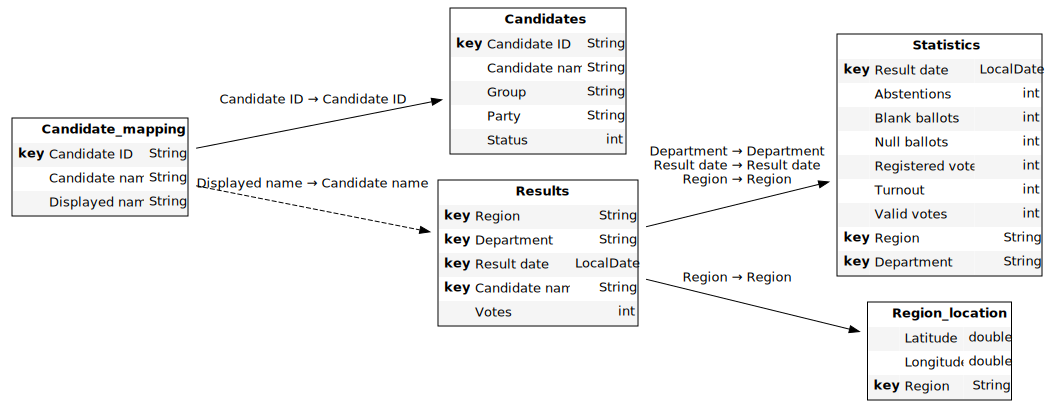

In [15]:
cube.schema

## 7. Manipulating atoti cube  

Hierarchies, levels and measures are different properties of the cube.  
A hierarchy can be single or multiple levels and we can draw insights from the measures along the hierarchies.  
Look at the [atoti tutorial](https://docs.atoti.io/latest/tutorial/tutorial.html#) to find out more.  

📑 The hierarchy slicing, level sorting and measure definitions below can be found in [create_cubes.py](https://github.com/atoti/project-template/blob/main/app/create_cubes.py) within the project.

In [16]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 7.1 Slicing hierarchy

There are two rounds of elections:
- 10 April 2022
- 24 April 2022

By slicing on the `Result date` hierarchy, this allows us to view only one date at a time. This is important because we do not want to sum up the votes across the two days.  
Slicing will return the first member of the hierarchy by default (ignoring the N/A date value).

In [17]:
h["Result date"].slicing = True

In [18]:
session.visualize("Cube querying with slicing on Result date")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [19]:
session.visualize("Number of candidates involved in the election")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

From the two tables above, we can see that without adding `Result date` hierarchy in the query, we are only looking at the number of candidates left after round 2 election.  
There were originally 32 candidates, 12 candidates left after round 1 and finally, the two final candidates for round 2.

### 7.2 Sorting level

We can define the [sorting order](https://docs.atoti.io/latest/lib/atoti/atoti.order.html#atoti.Order) of the members in a hierarchy.  
By sorting the `Result date` in descending order below, it will affect the result returned by the slicing.

In [20]:
l["Result date"].order = tt.NaturalOrder(ascending=False)

In [21]:
session.visualize("Cube querying with slicing on Result date after sorting")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 7.3 Creating measures  

With atoti, we can perform [aggregations](https://docs.atoti.io/latest/lib/atoti/atoti.agg.html#module-atoti.agg) and [other functions](https://docs.atoti.io/latest/lib/atoti/atoti.function.html#module-atoti.function) such as computing [parent total](https://docs.atoti.io/latest/lib/atoti/atoti.function.parent_value.html) or [date shift](https://docs.atoti.io/latest/lib/atoti/atoti.function.date_shift.html).  

Let's try creating some measures.

In [22]:
m["Number of departments"] = tt.agg.count_distinct(results_tbl["Department"])
m["Number of regions"] = tt.agg.count_distinct(results_tbl["Region"])

In [23]:
session.visualize("Participating regions and departments")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [24]:
m["Votes"] = tt.value(
    results_tbl["Votes"],
    levels=[l["Result date"], l["Region"], l["Department"], l["Candidate name"]],
)

In [25]:
session.visualize("Votes by departments across regions")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [26]:
m["Total votes across departments"] = tt.agg.sum(
    m["Votes"], scope=tt.scope.origin(l["Candidate name"])
)

In [27]:
session.visualize("Total votes across departments")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 7.3.1 Creating measures recursively

We can also create the measures recursively if the measures follows a pattern:

In [28]:
m_name_stats = [
    ele
    for ele in stats_tbl.columns
    if ele not in ["Result date", "Department", "Region"]
]

for m_name in m_name_stats:
    m[m_name] = tt.value(stats_tbl[m_name], levels=[l["Department"], l["Region"]])

    m[f"Total {m_name}".capitalize()] = tt.agg.sum(m[m_name])

In [29]:
m

Measures()

We saw that a measure is created for each of the numerical columns in the statistics table.  
We create the total measures to sum up the underlying value depending on what is being queried.

Note on the statistics:
```
total valid votes = total blank ballots + total null ballots + Total turnout
total registered votes = total valid votes + total abstentions
```

In [30]:
session.visualize("Breakdown of statistics by departments")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 7.3.2 Chaining up the measures  

We can make use of existing measures to compute other measures as shown below.  

In [31]:
m["% votes against reg. votes"] = (
    m["Total votes across departments"] / m["Total registered voters"]
)
m["% votes against reg. votes"].formatter = "DOUBLE[0.000%]"

In [32]:
session.visualize("Performance in top 5 regions with the most registered voters")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [33]:
m["% votes against turnout"] = m["Total votes across departments"] / m["Total turnout"]
m["% votes against turnout"].formatter = "DOUBLE[0.000%]"

In [34]:
session.visualize("Performance in top 5 regions with the most turnout voters")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [35]:
m["% valid vote"] = m["Total valid votes"] / m["Total registered voters"]
m["% blank ballots"] = m["Total blank ballots"] / m["Total registered voters"]
m["% null ballots"] = m["Total null ballots"] / m["Total registered voters"]
m["% abstentions"] = m["Total abstentions"] / m["Total registered voters"]

m["Total invalid votes"] = (
    m["Total blank ballots"] + m["Total null ballots"] + m["Total abstentions"]
)
m["% invalid votes"] = m["Total invalid votes"] / m["Total registered voters"]

We can define a measure to return the candidate leading for each region based on the number of votes.

In [36]:
m["Winning candidates"] = tt.agg.max_member(
    m["Total votes across departments"], l["Candidate name"]
)
m["Winning votes"] = tt.agg.max(
    m["Total votes across departments"], scope=tt.scope.origin(l["Candidate name"])
)

Seems like the most of the regions previously supporting Jean-Luc Mélenchon is now supporting Marine Le Pen.  
In Bourgogne-Franche-Comté, Grand Est and Occitanie, the support swings drastically from Marine Le Pen to Emmanuel Macron.

In [37]:
session.visualize("Winning candidates")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's look at the pseudo-location of the votes for the candidates.

In [38]:
m["Latitude"] = tt.value(location_tbl["Latitude"], levels=[l["Region"]])
m["Longitude"] = tt.value(location_tbl["Longitude"], levels=[l["Region"]])

We can see yellow, orange and purple dorminating the various regions.  
During the first round, Jean-Luc Mélenchon is very strong in Île-de-France and the votes went to Emmanuel Macron in the second round.  
Overall, Emmanuel Macron has higher support in most regions than Marine Le Pen.

In [39]:
session.visualize("Votes by candidates within France")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 7.3.3 Formatting measures

Below, we iterate through the names of the measures and set the formatting of those with `%` to percentage with 3 decimal places.

In [40]:
for measure_name in m.keys():
    if "% " in measure_name:
        m[measure_name].formatter = "DOUBLE[0.000%]"

From [previous elections](https://edition.cnn.com/2017/05/08/europe/french-voters-spoiled-ballots-abstained/index.html), we know that null, blank and abstained votes could represent a group who is not satisfied with any of the candidates available. Let's take a look at the composition of these populations.  

There's a higher percentage of invalid votes during the second round of voting.

In [41]:
session.visualize("Proportion of registered voters who spoiled vote or abstained")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [42]:
session.visualize("Votes compositions against registered voters")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## 8. Accessing web application  

Access the web application from the link below.  

In [43]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Access saved dashboard to get better insights.

In [44]:
session.link(path="/#/dashboard/a7a")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

Now that we have our data schema and measures, we can translate it into a project.  
Have a look at the [GitHub project on French presidential election](https://github.com/atoti/french-presidential-election) to see the equivalent of this notebook.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=french-election" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>